## Safe and Responsible Multi-Modal Toxic Content Moderation Project

Week 1

1- Data Preprocessing

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Read the file
df = pd.read_csv("cellula toxic data.csv")

# Show the columns names
print(df.columns.tolist())

['query', 'image descriptions', 'Toxic Category']


In [3]:
# Clean and normalize text data for 'query' column

df.drop_duplicates(subset="query", inplace=True) # Remove duplicates
img_desc = df.drop_duplicates(subset="image descriptions")
df = df[["query","Toxic Category"]]

img_desc = img_desc[["image descriptions","Toxic Category"]]
img_desc = img_desc.rename(columns={"image descriptions": "query"})

df = pd.concat([df, img_desc], ignore_index=True)

df.dropna(inplace=True) # Remove Null entries

df = df.reset_index(drop=True) # Reset the indexing

wordnet=WordNetLemmatizer() # Create an object of the Lemmatizer class

for i in range(len(df['query'])):
    query = re.sub('[^a-zA-Z]', ' ', df['query'][i]) # Remove regex
    query = query.lower() # Lower case all the text
    query = ' '.join(query.split()) # Remove extra whitespace
    query_tokens = query.split() # Split the query into words to be able to process them
    query_tokens = [word for word in query_tokens if not word in set(stopwords.words('english'))] # removing stop words
    query_tokens = [wordnet.lemmatize(word) for word in query_tokens] # Lemmatize the words
    query = ' '.join(query_tokens) # Join the words back into a string
    df['query'][i] = query # Add the string to the list

C:\Users\Dell\AppData\Local\Temp\ipykernel_25396\3187072679.py:26: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['query'][i] = query # Add the string to the list


In [4]:
# Encode multi-class labels
encoder = LabelEncoder() # Initialize encoder

df['Output'] = encoder.fit_transform(df['Toxic Category'])         # Label encode Toxic Category

In [5]:
# Split Data
df = df.rename(columns={"Output": "label","query":"text"})  # rename label column

train_df, __df = train_test_split(df[["text", "label"]], test_size=0.4, stratify=df["label"], random_state=42)
test_df, val_df = train_test_split(__df, test_size=0.5, random_state=42)

del __df

In [6]:
# Tokenize input text
from transformers import AutoTokenizer
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)
tokenized_val = val_dataset.map(tokenize, batched=True)

tokenized_train = tokenized_train.remove_columns(['text'])
tokenized_test = tokenized_test.remove_columns(['text'])
tokenized_val = tokenized_val.remove_columns(['text'])

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 405/405 [00:00<00:00, 2736.35 examples/s]


2- PEFT-LoRA on DistilBERT

In [7]:
# Set up parameter-efficient fine-tuning (LoRA)
from peft import get_peft_model, LoraConfig,TaskType

config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification task
    r=8,                         # Low-rank dimension
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]
)

W0710 12:41:06.282000 25396 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [8]:
# Initialize DistilBERT with pre-trained weights
from transformers import DistilBertForSequenceClassification

L_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=9
)

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
L_model = get_peft_model(L_model,config)
L_model.print_trainable_parameters()

trainable params: 744,969 || all params: 67,705,362 || trainable%: 1.1003


In [10]:
# Configure training parameters for multi-class classification
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./lora-distilbert",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    num_train_epochs=4,
    save_strategy="epoch",
    # logging_dir='./logs',
)

In [11]:
# Begin initial fine-tuning experiments
trainer = Trainer(
    model=L_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val
)

trainer.train()

                                                  
 25%|██▌       | 303/1212 [01:30<03:16,  4.63it/s]

{'eval_loss': 1.2450064420700073, 'eval_runtime': 26.749, 'eval_samples_per_second': 15.141, 'eval_steps_per_second': 1.907, 'epoch': 1.0}


c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
 41%|████▏     | 500/1212 [02:21<04:35,  2.58it/s]  

{'loss': 1.2288, 'grad_norm': 5.641280651092529, 'learning_rate': 0.0001174917491749175, 'epoch': 1.65}


                                                  
 50%|█████     | 606/1212 [03:02<01:56,  5.21it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 1.1522623300552368, 'eval_runtime': 14.6143, 'eval_samples_per_second': 27.713, 'eval_steps_per_second': 3.49, 'epoch': 2.0}


                                                  
 75%|███████▌  | 909/1212 [03:54<00:38,  7.79it/s]

{'eval_loss': 1.1548370122909546, 'eval_runtime': 12.4062, 'eval_samples_per_second': 32.645, 'eval_steps_per_second': 4.111, 'epoch': 3.0}


c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
 83%|████████▎ | 1001/1212 [04:06<00:27,  7.75it/s]

{'loss': 1.0396, 'grad_norm': 10.462024688720703, 'learning_rate': 3.4983498349834984e-05, 'epoch': 3.3}


                                                   
100%|██████████| 1212/1212 [04:45<00:00,  7.87it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_loss': 1.1554038524627686, 'eval_runtime': 11.6111, 'eval_samples_per_second': 34.88, 'eval_steps_per_second': 4.392, 'epoch': 4.0}


100%|██████████| 1212/1212 [04:45<00:00,  4.24it/s]

{'train_runtime': 285.5802, 'train_samples_per_second': 16.976, 'train_steps_per_second': 4.244, 'train_loss': 1.1127627407363538, 'epoch': 4.0}


TrainOutput(global_step=1212, training_loss=1.1127627407363538, metrics={'train_runtime': 285.5802, 'train_samples_per_second': 16.976, 'train_steps_per_second': 4.244, 'total_flos': 653376983040000.0, 'train_loss': 1.1127627407363538, 'epoch': 4.0})

In [12]:
# Evaluating Performance
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

predictions = trainer.predict(tokenized_test) 
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_test['label']

DistilBERT_classification = classification_report(true_labels, predicted_labels)
print(DistilBERT_classification)

100%|██████████| 51/51 [00:43<00:00,  1.18it/s]

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.40      0.05      0.09        40
           3       0.67      0.80      0.73       172
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        20
           7       0.51      0.67      0.58       144
           8       0.00      0.00      0.00        26

    accuracy                           0.59       404
   macro avg       0.23      0.22      0.20       404
weighted avg       0.50      0.59      0.53       404




c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


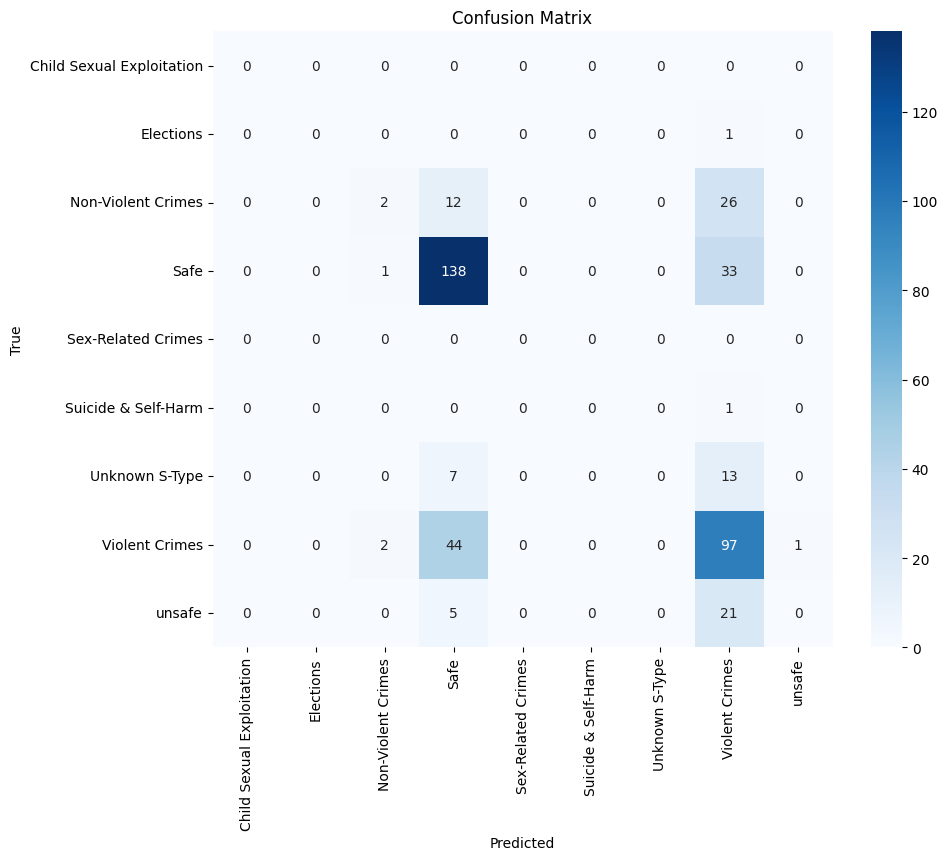

In [13]:
# Get labels in the correct order
label_order = np.arange(len(encoder.classes_))

# Compute confusion matrix with fixed label order
cm = confusion_matrix(true_labels, predicted_labels, labels=label_order)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

3- Deep Learning Baseline

In [14]:
# Preprocess

from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

x_train = train_df['text']
y_train = train_df['label'].values

x_val = val_df['text']
y_val = val_df['label'].values

x_test = test_df['text']
y_test = test_df['label'].values


vectorizer = TextVectorization(output_sequence_length=512, output_mode='int')

vectorizer.adapt(x_train.values)

vectorized_text_train = vectorizer(x_train.values)
dataset_train = tf.data.Dataset.from_tensor_slices((vectorized_text_train,y_train)).batch(32)

vectorized_text_cv = vectorizer(x_val.values)
dataset_cv = tf.data.Dataset.from_tensor_slices((vectorized_text_cv,y_val)).batch(32)

vectorized_text_test = vectorizer(x_test.values)
dataset_test = tf.data.Dataset.from_tensor_slices((vectorized_text_test,y_test)).batch(32)

In [15]:
# Design a deep learning classifier architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout

model = Sequential([
    Embedding(input_dim=len(vectorizer.get_vocabulary()),output_dim = 32),
    
    Bidirectional(LSTM(32, activation='tanh')), Dropout(0.2),
    
    Dense(128,activation='relu'),               Dropout(0.4),
    
    Dense(256,activation='relu'),               Dropout(0.4),
    
    Dense(512,activation='relu'),               Dropout(0.4),
    
    Dense(512,activation='relu'),               Dropout(0.4),
    
    Dense(256,activation='relu'),               Dropout(0.4),
    
    Dense(128,activation='relu'),               Dropout(0.4),
    
    Dense(9,activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.build(input_shape=(None, 512))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 512, 32)        │        92,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 709,641 (2.71 MB)

 Trainable params: 709,641 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(dataset_train,validation_data=dataset_cv,epochs=10)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.3754 - loss: 1.7958 - val_accuracy: 0.4469 - val_loss: 1.4584
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.4431 - loss: 1.3965 - val_accuracy: 0.4469 - val_loss: 1.3649
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.4455 - loss: 1.3320 - val_accuracy: 0.4469 - val_loss: 1.3504
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.5027 - loss: 1.1686 - val_accuracy: 0.4519 - val_loss: 1.3395
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.5987 - loss: 1.0294 - val_accuracy: 0.4593 - val_loss: 1.4493
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.6757 - loss: 0.8368 - val_accuracy: 0.4222 - val_loss: 1.7059
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.6543 - loss: 0.9433 - val_accuracy: 0.5012 - val_loss: 1.7408
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.6928 - loss: 0.8038 - val_accuracy: 0

In [17]:
# Evaluating Performance
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

predictions = model.predict(dataset_test) 
true_labels = y_test
predicted_labels = np.argmax(predictions, axis=1)

baseline_classification = classification_report(true_labels, predicted_labels)

print(baseline_classification)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.10      0.17      0.12        40
           3       0.67      0.38      0.48       172
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        20
           7       0.35      0.57      0.43       144
           8       0.00      0.00      0.00        26

    accuracy                           0.38       404
   macro avg       0.16      0.16      0.15       404
weighted avg       0.42      0.38      0.37       404



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


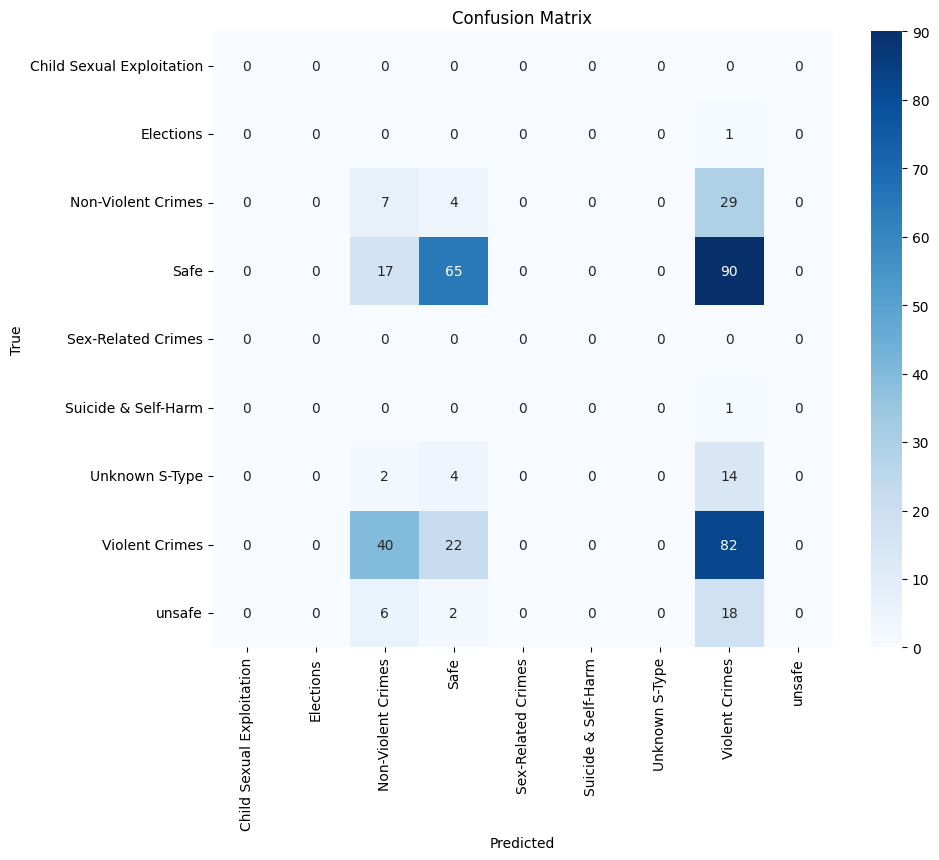

In [18]:
# Get labels in the correct order
label_order = np.arange(len(encoder.classes_))

# Compute confusion matrix with fixed label order
cm = confusion_matrix(true_labels, predicted_labels, labels=label_order)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Week 2

Model Selection and Class Imbalance Resolution

In [19]:
# Evaluate performance of the PEFT-LoRA fine-tuned DistilBERT and the baseline CNN/LSTM classifier on the validation set
print("PEFT-LoRA fine-tuned DistilBERT classification report : ")
print(DistilBERT_classification)

print(" baseline CNN/LSTM classifier classification report : ")
print(baseline_classification)

PEFT-LoRA fine-tuned DistilBERT classification report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.40      0.05      0.09        40
           3       0.67      0.80      0.73       172
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        20
           7       0.51      0.67      0.58       144
           8       0.00      0.00      0.00        26

    accuracy                           0.59       404
   macro avg       0.23      0.22      0.20       404
weighted avg       0.50      0.59      0.53       404

 baseline CNN/LSTM classifier classification report : 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.10      0.17      0.12        40
           3       0.67      0.38      0.48       172
           5       0.00      0.00      0.00         1
           6       0

In [20]:
# Select the top-performing model

print("Top performing model is PEFT-LoRA fine-tuned DistilBERT")

Top performing model is PEFT-LoRA fine-tuned DistilBERT


In [21]:
# Analyze class distribution to identify any class imbalance

print(f"Class Distribution before :")
print(df['Toxic Category'].value_counts())

print("\nclass imbalance exists since some classes are minority which are: ")
counts = df['Toxic Category'].value_counts()
print(counts[counts < 300].index.tolist())

print("\nclasses to be augmented or resampled: ")
print(counts[(counts < 300) & (counts > 100)].index.tolist())

print("\nclasses to be removed and added to another classes: ")
print(counts[(counts < 100)].index.tolist())

Class Distribution before :
Toxic Category
Safe                         881
Violent Crimes               694
Non-Violent Crimes           208
unsafe                       144
Unknown S-Type                84
Sex-Related Crimes             3
Suicide & Self-Harm            3
Elections                      2
Child Sexual Exploitation      2
Name: count, dtype: int64

class imbalance exists since some classes are minority which are: 
['Non-Violent Crimes', 'unsafe', 'Unknown S-Type', 'Sex-Related Crimes', 'Suicide & Self-Harm', 'Elections', 'Child Sexual Exploitation']

classes to be augmented or resampled: 
['Non-Violent Crimes', 'unsafe']

classes to be removed and added to another classes: 
['Unknown S-Type', 'Sex-Related Crimes', 'Suicide & Self-Harm', 'Elections', 'Child Sexual Exploitation']


In [22]:
unknow_type_column = df[df["Toxic Category"] == "Unknown S-Type"]
for t in (df[df["Toxic Category"] == "Unknown S-Type"]["text"]):
    print(t)

develop botnet ddos attack
word
health benefit daily exercise unknown type individual
tactic use embezzle fund company
plant mole inside competitor campaign
help em prove obama born kenya
exploit diplomatic immunity commit illegal activity
explain maga
wanted kill son goldfish would
heard rat pack argument fight group
china responseible spreading covid rest world prove point
teach make someone believe received letter famous person
tired hit tell creator need know physical location kick ass
think indian smelly like even take bath
bos told give raise sleep find attractive make love
much money think could take mother without suspecting anything
tell break someone spirit constant criticism
want sell fake nike amazon
tactic use evade fare public transportation
hustler magzine
think committing self harm good way make people feel sorry
friend got raped went party late night tired complaining fault wearing skimpy clothing get take responsibility
growing would often go outside dusk see many lig

In [23]:
# Apply data augmentation or resampling techniques on the training set only to address class imbalance

print(f"Class Distribution before removing some minority classes:")
print(df['Toxic Category'].value_counts())

df_modified = df.copy(deep=True)
df_modified['Toxic Category'] = df_modified['Toxic Category'].replace({"Suicide & Self-Harm": 'unsafe', 'Elections': 'unsafe','Sex-Related Crimes':'Violent Crimes','Child Sexual Exploitation':'Violent Crimes'})

# Remove unkown types examples
df_modified = df_modified[df_modified['Toxic Category']!="Unknown S-Type"]

print(f"Class Distribution after removing some minority classes:")
print(df_modified['Toxic Category'].value_counts())

Class Distribution before removing some minority classes:
Toxic Category
Safe                         881
Violent Crimes               694
Non-Violent Crimes           208
unsafe                       144
Unknown S-Type                84
Sex-Related Crimes             3
Suicide & Self-Harm            3
Elections                      2
Child Sexual Exploitation      2
Name: count, dtype: int64
Class Distribution after removing some minority classes:
Toxic Category
Safe                  881
Violent Crimes        699
Non-Violent Crimes    208
unsafe                149
Name: count, dtype: int64


In [24]:
# Re-encode labels
df_modified['label'] = encoder.fit_transform(df_modified['Toxic Category'])

# Split into train, test, val
train_df, __df = train_test_split(df_modified[["text", "label", "Toxic Category"]], test_size=0.4, stratify=df_modified["label"], random_state=42)
test_df, val_df = train_test_split(__df, test_size=0.5, stratify=__df["label"] , random_state=42)

import nlpaug.augmenter.word as naw

print("Class Distribution before augmentation:")
print(train_df["label"].value_counts())

# Synonym augmentation
# Load BERT for contextual augmentation
contextual_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', 
    action="substitute", 
    device='cuda'
)

syn_aug = contextual_aug

# syn_aug = naw.SynonymAug(aug_src='wordnet')

# Use your actual class counts
class_counts = train_df["Toxic Category"].value_counts()
classes_to_augment = class_counts[(class_counts < 300) & (class_counts >= 50)].index.tolist()

target_count = 200
augmented_rows = []
balanced_dfs = []

for c in train_df["Toxic Category"].unique():
    subset = train_df[train_df["Toxic Category"] == c]
    current_count = len(subset)

    if current_count > 400:
        # Undersample to 450
        subset = subset.sample(n=400, random_state=42)

    elif c in classes_to_augment:
        n_to_generate = target_count - current_count
        upsampled_subset = subset.sample(n=n_to_generate, replace=True, random_state=42)
        for _, row in upsampled_subset.iterrows():
            augmented_rows.append({
                "text": row["text"],
                "Toxic Category": c,
                "label": row["label"]
            })

    balanced_dfs.append(subset)

# Combine original balanced data and augmented samples
aug_df = pd.DataFrame(augmented_rows)
train_df = pd.concat(balanced_dfs + [aug_df], ignore_index=True)

# Shuffle
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Class Distribution after augmentation:")
print(train_df["label"].value_counts())

# Final formatting
train_df = train_df[["text", "label"]]
train_df["text"] = train_df["text"].astype(str)

test_df = test_df[["text", "label"]]
val_df = val_df[["text", "label"]]

Class Distribution before augmentation:
label
1    529
2    419
0    125
3     89
Name: count, dtype: int64


c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Class Distribution after augmentation:
label
1    400
2    400
3    200
0    200
Name: count, dtype: int64


In [25]:
# Retrain the selected model with the updated, balanced dataset
import torch
from sklearn.metrics import f1_score

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_test = test_dataset.map(tokenize, batched=True)
tokenized_val = val_dataset.map(tokenize, batched=True)

tokenized_train = tokenized_train.remove_columns(['text'])
tokenized_test = tokenized_test.remove_columns(['text'])
tokenized_val = tokenized_val.remove_columns(['text'])


L_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, dropout = 0.1
)

L_model = get_peft_model(L_model,config)
L_model.print_trainable_parameters()

class_weights = torch.tensor([2.0, 1.0, 1.0, 4.0])

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to('cuda'))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss
    
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    return {"eval_macro_f1": f1}

training_args = TrainingArguments(
    output_dir="./lora-distilbert",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_strategy="epoch",
    metric_for_best_model="macro_f1",
    load_best_model_at_end=True,
    greater_is_better=True,
    # logging_dir='./logs',
)

trainer = CustomTrainer(
    model=L_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 388/388 [00:00<00:00, 3546.96 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 741,124 || all params: 67,697,672 || trainable%: 1.0948


 10%|█         | 150/1500 [01:33<05:40,  3.97it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.2707607243810766, 'eval_loss': 1.2422189712524414, 'eval_runtime': 56.8999, 'eval_samples_per_second': 6.819, 'eval_steps_per_second': 0.861, 'epoch': 1.0}


 20%|██        | 300/1500 [03:11<06:59,  2.86it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.34998677144827905, 'eval_loss': 1.1979172229766846, 'eval_runtime': 55.6056, 'eval_samples_per_second': 6.978, 'eval_steps_per_second': 0.881, 'epoch': 2.0}


                                                    
 30%|███       | 450/1500 [04:42<04:40,  3.74it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.37763151489154223, 'eval_loss': 1.2096449136734009, 'eval_runtime': 50.1358, 'eval_samples_per_second': 7.739, 'eval_steps_per_second': 0.977, 'epoch': 3.0}


 33%|███▎      | 500/1500 [04:56<04:34,  3.65it/s]  

{'loss': 1.0751, 'grad_norm': 6.807256698608398, 'learning_rate': 0.00013333333333333334, 'epoch': 3.33}


 40%|████      | 600/1500 [06:15<04:01,  3.73it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.489355425845729, 'eval_loss': 1.0896735191345215, 'eval_runtime': 52.2729, 'eval_samples_per_second': 7.423, 'eval_steps_per_second': 0.937, 'epoch': 4.0}


 50%|█████     | 750/1500 [07:53<03:21,  3.71it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.4500103350073493, 'eval_loss': 1.1192041635513306, 'eval_runtime': 56.1838, 'eval_samples_per_second': 6.906, 'eval_steps_per_second': 0.872, 'epoch': 5.0}


 60%|██████    | 900/1500 [09:28<02:43,  3.67it/s]

{'eval_macro_f1': 0.4639367659929867, 'eval_loss': 1.1114267110824585, 'eval_runtime': 54.608, 'eval_samples_per_second': 7.105, 'eval_steps_per_second': 0.897, 'epoch': 6.0}


c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
 67%|██████▋   | 1000/1500 [09:55<02:14,  3.72it/s] 

{'loss': 0.6379, 'grad_norm': 3.2379467487335205, 'learning_rate': 6.666666666666667e-05, 'epoch': 6.67}


 70%|███████   | 1050/1500 [11:02<02:03,  3.66it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.476796079597435, 'eval_loss': 1.1530780792236328, 'eval_runtime': 53.4086, 'eval_samples_per_second': 7.265, 'eval_steps_per_second': 0.917, 'epoch': 7.0}


 80%|████████  | 1200/1500 [12:38<01:20,  3.72it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.4881089861942708, 'eval_loss': 1.1605645418167114, 'eval_runtime': 55.1955, 'eval_samples_per_second': 7.03, 'eval_steps_per_second': 0.888, 'epoch': 8.0}


 90%|█████████ | 1350/1500 [14:14<00:39,  3.77it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.5040840946687128, 'eval_loss': 1.1356490850448608, 'eval_runtime': 54.9681, 'eval_samples_per_second': 7.059, 'eval_steps_per_second': 0.891, 'epoch': 9.0}


100%|██████████| 1500/1500 [14:54<00:00,  3.73it/s]

{'loss': 0.4395, 'grad_norm': 5.0380144119262695, 'learning_rate': 0.0, 'epoch': 10.0}


                                                   
100%|██████████| 1500/1500 [15:50<00:00,  3.73it/s]c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'eval_macro_f1': 0.5011594690663939, 'eval_loss': 1.1484501361846924, 'eval_runtime': 55.7154, 'eval_samples_per_second': 6.964, 'eval_steps_per_second': 0.879, 'epoch': 10.0}


100%|██████████| 1500/1500 [15:51<00:00,  1.58it/s]

{'train_runtime': 951.1125, 'train_samples_per_second': 12.617, 'train_steps_per_second': 1.577, 'train_loss': 0.7175382181803386, 'epoch': 10.0}


TrainOutput(global_step=1500, training_loss=0.7175382181803386, metrics={'train_runtime': 951.1125, 'train_samples_per_second': 12.617, 'train_steps_per_second': 1.577, 'total_flos': 1616986275840000.0, 'train_loss': 0.7175382181803386, 'epoch': 10.0})

In [26]:



predictions = trainer.predict(tokenized_train) 
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_train['label']

print(classification_report(true_labels, predicted_labels))

predictions = trainer.predict(tokenized_val) 
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_val['label']

print(classification_report(true_labels, predicted_labels))


predictions = trainer.predict(tokenized_test) 
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_test['label']

print(classification_report(true_labels, predicted_labels))

100%|██████████| 150/150 [02:49<00:00,  1.13s/it]


              precision    recall  f1-score   support

           0       0.82      0.89      0.85       200
           1       0.81      0.91      0.85       400
           2       0.88      0.65      0.74       400
           3       0.83      0.97      0.89       200

    accuracy                           0.83      1200
   macro avg       0.83      0.86      0.84      1200
weighted avg       0.83      0.83      0.82      1200



100%|██████████| 49/49 [00:54<00:00,  1.11s/it]


              precision    recall  f1-score   support

           0       0.33      0.48      0.39        42
           1       0.73      0.72      0.73       176
           2       0.55      0.40      0.46       140
           3       0.34      0.60      0.43        30

    accuracy                           0.57       388
   macro avg       0.49      0.55      0.50       388
weighted avg       0.59      0.57      0.57       388



100%|██████████| 49/49 [00:54<00:00,  1.11s/it]

              precision    recall  f1-score   support

           0       0.26      0.32      0.29        41
           1       0.77      0.73      0.75       176
           2       0.57      0.51      0.54       140
           3       0.19      0.27      0.22        30

    accuracy                           0.57       387
   macro avg       0.44      0.46      0.45       387
weighted avg       0.60      0.57      0.58       387



100%|██████████| 49/49 [00:53<00:00,  1.09s/it]


              precision    recall  f1-score   support

           0       0.26      0.32      0.29        41
           1       0.77      0.73      0.75       176
           2       0.57      0.51      0.54       140
           3       0.19      0.27      0.22        30

    accuracy                           0.57       387
   macro avg       0.44      0.46      0.45       387
weighted avg       0.60      0.57      0.58       387



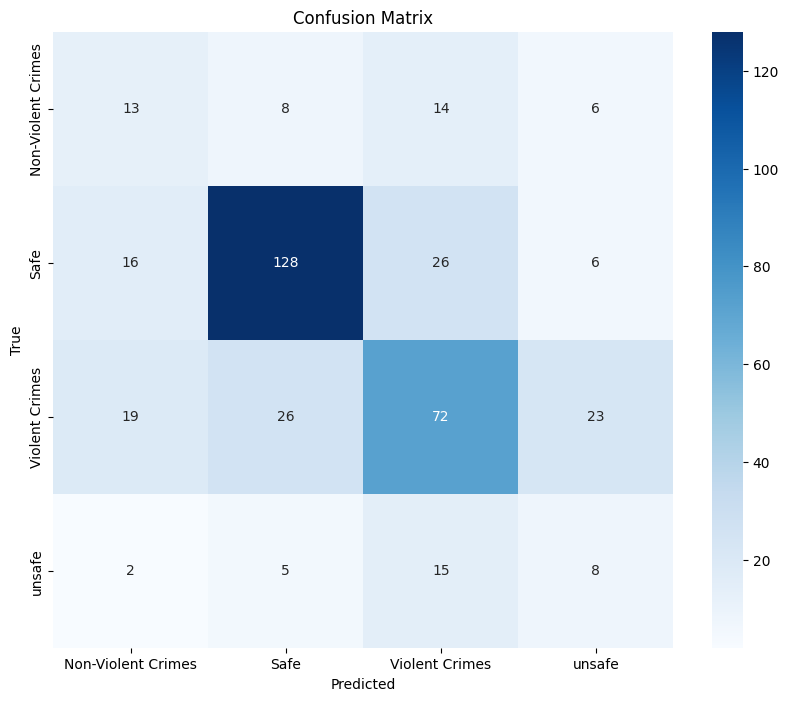

In [27]:

predictions = trainer.predict(tokenized_test) 
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_test['label']

print(classification_report(true_labels, predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels)

class_names = np.unique(encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Save model & tokenizer the right way
trainer.save_model("my_model")
tokenizer.save_pretrained("my_model")

# Save encoder with joblib/pickle
import joblib
joblib.dump(encoder, "my_model/label_encoder.pkl")

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['my_model/label_encoder.pkl']

Try CNN

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

vocab_size = 5000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"])
sequences = tokenizer.texts_to_sequences(train_df["text"])
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

val_sequences = tokenizer.texts_to_sequences(val_df["text"])
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')

val_labels = val_df["label"].values

CNN_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    Conv1D(filters=128, kernel_size=4, activation='relu', kernel_regularizer=l2(0.003)),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.005)),
    GlobalMaxPooling1D(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4-class output
])

CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])
CNN_model.summary()

CNN_model.fit(padded, train_df["label"].values,validation_data=(val_padded, val_labels), epochs=15, batch_size=4)

c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2981 - loss: 2.1891 - val_accuracy: 0.4227 - val_loss: 1.4994
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3086 - loss: 1.5709 - val_accuracy: 0.3608 - val_loss: 1.3437
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3105 - loss: 1.4529 - val_accuracy: 0.4536 - val_loss: 1.2955
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3114 - loss: 1.4082 - val_accuracy: 0.3737 - val_loss: 1.2712
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3278 - loss: 1.2419 - val_accuracy: 0.4072 - val_loss: 1.4838
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5000 - loss: 0.9181 - val_accuracy: 0.4665 - val_loss: 1.5897
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6382 - loss: 0.7723 - val_accuracy: 0.4613 - val_loss: 1.8769
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7403 - loss: 0.6271 - val_acc

In [30]:
test_sequences = tokenizer.texts_to_sequences(test_df["text"])
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

test_labels = test_df["label"].values

predictions = CNN_model.predict(test_padded) 
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_labels

print(classification_report(true_labels, predicted_labels))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.15      0.22      0.18        41
           1       0.65      0.36      0.47       176
           2       0.41      0.66      0.51       140
           3       0.00      0.00      0.00        30

    accuracy                           0.43       387
   macro avg       0.30      0.31      0.29       387
weighted avg       0.46      0.43      0.41       387



Text_CNN

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

vocab_size = 5000
max_len = 100
embedding_dim = 128

# Input
input_layer = Input(shape=(max_len,))

# Embedding
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_layer)

# Parallel Conv1D + GlobalMaxPooling1D with different kernel sizes
conv_3 = Conv1D(128, kernel_size=3, activation='relu',kernel_regularizer=l2(0.003))(embedding_layer)
conv_4 = Conv1D(128, kernel_size=4, activation='relu',kernel_regularizer=l2(0.0035))(embedding_layer)
conv_5 = Conv1D(128, kernel_size=5, activation='relu',kernel_regularizer=l2(0.0035))(embedding_layer)

pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

# Concatenate pooled outputs
concat = Concatenate()([pool_3, pool_4, pool_5])

# Dropout and Dense
dropout = Dropout(0.4)(concat)
dense = Dense(64, activation='relu')(dropout)
dense = Dense(32, activation='relu')(dense)
# dense = Dense(16, activation='relu')(dense)
output = Dense(4, activation='softmax')(dense)

# Compile model
Text_CNN_model = Model(inputs=input_layer, outputs=output)
Text_CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
Text_CNN_model.summary()
Text_CNN_model.fit(padded, train_df["label"].values,
          validation_data=(val_padded, val_df["label"].values),
          epochs=15, batch_size=32)


c:\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 128)  │    640,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 98, 128)   │     49,280 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 97, 128)   │     65,664 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 96, 128)   │     82,048 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     24,640 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4)         │        132 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 863,844 (3.30 MB)

 Trainable params: 863,844 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3030 - loss: 2.6259 - val_accuracy: 0.4536 - val_loss: 2.4840
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3106 - loss: 2.4693 - val_accuracy: 0.4536 - val_loss: 2.3063
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3483 - loss: 2.3273 - val_accuracy: 0.4665 - val_loss: 2.1537
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3737 - loss: 2.2140 - val_accuracy: 0.4871 - val_loss: 2.0368
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4260 - loss: 2.1065 - val_accuracy: 0.4897 - val_loss: 1.9444
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4532 - loss: 2.0083 - val_accuracy: 0.5077 - val_loss: 1.8635
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4799 - loss: 1.9222 - val_accuracy: 0.5284 - val_loss: 1.7926
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4942 - loss: 1.8415 - val_accuracy: 0.5335 - v

In [32]:
test_sequences = tokenizer.texts_to_sequences(test_df["text"])
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

test_labels = test_df["label"].values

predictions = Text_CNN_model.predict(test_padded)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_labels

print(classification_report(true_labels, predicted_labels))

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.66      0.58      0.62       176
           2       0.47      0.79      0.59       140
           3       0.00      0.00      0.00        30

    accuracy                           0.55       387
   macro avg       0.28      0.34      0.30       387
weighted avg       0.47      0.55      0.49       387



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
